# Collecting data on decentralized exchanges using BitQuery GraphQL API

**First we define how to run a query using API key from BitQuery**

In [17]:
import requests
import yaml

with open('api.yaml', 'r') as f:
    parsed_yaml = yaml.load(f, Loader=yaml.FullLoader)
    API_KEY = parsed_yaml['api']


def run_query(query):  # A simple function to use requests.post to make the API call.
    headers = {'X-API-KEY': API_KEY}
    request = requests.post('https://graphql.bitquery.io/', json={'query': query, 'variables': variables}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed and return code is {}.      {}'.format(request.status_code, query))

**Define our first query, which fetches a summary of decentralized exchanges and the following metrics:**
- Trade count
- Currencies
- Contracts
- Volume in USD


In [26]:
variables = {
    "limit": 10,
    "offset": 0,
    "network": "ethereum",
    "from": "2021-01-01",
    "till": "2022-05-23T23:59:59",
    "dateFormat": "%Y-%m-%d"}

query1 = """
query ($network: EthereumNetwork!, $from: ISO8601DateTime, $till: ISO8601DateTime) {
  ethereum(network: $network) {
    dexTrades(options: {desc: "tradeAmount"}, date: {since: $from, till: $till}) {
      exchange {
        fullName
      }
      trades: count
      tradeAmount(in: USD)
      currencies: count(uniq: buy_currency)
      contracts: count(uniq: smart_contracts)
    }
  }
}
"""

result1 = run_query(query1)  # Execute the query
print('Result - {}'.format(result1))

Result - {'data': {'ethereum': {'dexTrades': [{'exchange': {'fullName': 'Uniswap'}, 'trades': 68729828, 'tradeAmount': 930680788036.5784, 'currencies': 40061, 'contracts': 57459}, {'exchange': {'fullName': 'SushiSwap'}, 'trades': 8176930, 'tradeAmount': 171643711595.57495, 'currencies': 1859, 'contracts': 2401}, {'exchange': {'fullName': '<Uniswap v2>'}, 'trades': 1750450, 'tradeAmount': 137562468413.51614, 'currencies': 838, 'contracts': 1716}, {'exchange': {'fullName': 'Zerox Exchange'}, 'trades': 567696, 'tradeAmount': 33301091625.820107, 'currencies': 1021, 'contracts': 3}, {'exchange': {'fullName': 'Curve'}, 'trades': 99492, 'tradeAmount': 23437422881.08056, 'currencies': 17, 'contracts': 7}, {'exchange': {'fullName': 'Bancor Network'}, 'trades': 712650, 'tradeAmount': 19144746475.78993, 'currencies': 305, 'contracts': 1}, {'exchange': {'fullName': 'Balancer'}, 'trades': 1109919, 'tradeAmount': 18290921483.002403, 'currencies': 720, 'contracts': 1369}, {'exchange': {'fullName': 'D

In [29]:
import pandas as pd

# Convert the result to a dataframe
df1 = pd.json_normalize(result1['data']['ethereum']['dexTrades'])
print(df1)
df1.to_csv(path_or_buf='1_exchange_overview.csv')

      trades   tradeAmount  currencies  contracts         exchange.fullName
0   68729828  9.306808e+11       40061      57459                   Uniswap
1    8176930  1.716437e+11        1859       2401                 SushiSwap
2    1750450  1.375625e+11         838       1716              <Uniswap v2>
3     567696  3.330109e+10        1021          3            Zerox Exchange
4      99492  2.343742e+10          17          7                     Curve
5     712650  1.914475e+10         305          1            Bancor Network
6    1109919  1.829092e+10         720       1369                  Balancer
7     106218  1.769370e+10          12         12                      Dodo
8     259607  1.424615e+10          62          2       <Zerox Exchange v2>
9      47945  1.330894e+10          18         11                   <Curve>
10    181095  9.799948e+09         232          2                     1inch
11    100334  8.893685e+09           3          1                      dYdX
12    210817

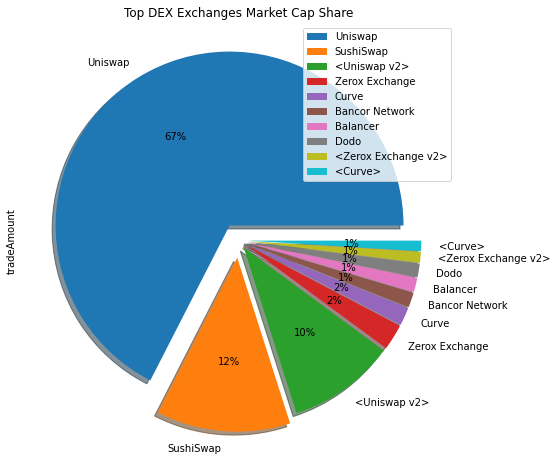

In [77]:
# Plot the data as a pie chart
pie = df1.head(10).plot(kind='pie',
                  y='tradeAmount',
                  autopct='%1.0f%%',
                  labels=df1['exchange.fullName'],
                  title='Top DEX Exchanges Market Cap Share',
                  explode=(0.10, 0.10, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05),
                  shadow=True,
                  figsize= (8,8))

pie.legend(loc='upper right')
fig = pie.get_figure()
fig.savefig('2_exchange_pie')

**Next we take a look at the top traded token pairs**

In [89]:
variables = {
    "limit": 50,
    "offset": 0,
    "network": "ethereum",
    "from": "2021-01-01",
    "till": "2022-05-23T23:59:59",
    "dateFormat": "%Y-%m-%d"}

query2 = """
query ($network: EthereumNetwork!, $limit: Int!, $offset: Int!, $from: ISO8601DateTime, $till: ISO8601DateTime) {
  ethereum(network: $network) {
    dexTrades(
      options: {desc: "tradeAmount", limit: $limit, offset: $offset}
      date: {since: $from, till: $till}
    ) {
      buyCurrency {
        symbol
      }
      sellCurrency {
        symbol
      }
      count
      tradeAmount(in: USD)
      started: minimum(of: date)
    }
  }
}
"""

result2 = run_query(query2)  # Execute the query
print('Result - {}'.format(result2))

Result - {'data': {'ethereum': {'dexTrades': [{'buyCurrency': {'symbol': 'WETH'}, 'sellCurrency': {'symbol': 'USDC'}, 'count': 3070624, 'tradeAmount': 171726157153.70316, 'started': '2021-01-01'}, {'buyCurrency': {'symbol': 'USDC'}, 'sellCurrency': {'symbol': 'WETH'}, 'count': 2709979, 'tradeAmount': 170413923012.6892, 'started': '2021-01-01'}, {'buyCurrency': {'symbol': 'SF'}, 'sellCurrency': {'symbol': 'WETH'}, 'count': 12, 'tradeAmount': 123568881602.26479, 'started': '2022-04-12'}, {'buyCurrency': {'symbol': 'WETH'}, 'sellCurrency': {'symbol': 'USDT'}, 'count': 2493167, 'tradeAmount': 66789949710.21434, 'started': '2021-01-01'}, {'buyCurrency': {'symbol': 'USDT'}, 'sellCurrency': {'symbol': 'WETH'}, 'count': 2572750, 'tradeAmount': 65515408300.6085, 'started': '2021-01-01'}, {'buyCurrency': {'symbol': 'DAI'}, 'sellCurrency': {'symbol': 'WETH'}, 'count': 876512, 'tradeAmount': 35393182683.11174, 'started': '2021-01-01'}, {'buyCurrency': {'symbol': 'WETH'}, 'sellCurrency': {'symbol':

In [98]:
# Convert the result to a dataframe
df2 = pd.json_normalize(result2['data']['ethereum']['dexTrades'])
df2['Trading Pair'] = df2['buyCurrency.symbol'] + '/' + df2['sellCurrency.symbol']
df2 = df2.drop(columns=['buyCurrency.symbol', 'sellCurrency.symbol'], axis=1)
print(df2)
df2.to_csv(path_or_buf='2_token_pairs.csv')

      count   tradeAmount     started                           Trading Pair
0   3070624  1.717262e+11  2021-01-01                              WETH/USDC
1   2709979  1.704139e+11  2021-01-01                              USDC/WETH
2        12  1.235689e+11  2022-04-12                                SF/WETH
3   2493167  6.678995e+10  2021-01-01                              WETH/USDT
4   2572750  6.551541e+10  2021-01-01                              USDT/WETH
5    876512  3.539318e+10  2021-01-01                               DAI/WETH
6    959649  3.515667e+10  2021-01-01                               WETH/DAI
7    377990  2.987831e+10  2021-01-01                              WBTC/WETH
8    410881  2.918024e+10  2021-01-01                              WETH/WBTC
9    295953  2.398256e+10  2021-01-01                              USDT/USDC
10   273766  2.397223e+10  2021-01-01                              USDC/USDT
11   127598  9.551488e+09  2021-01-01                               USDC/DAI

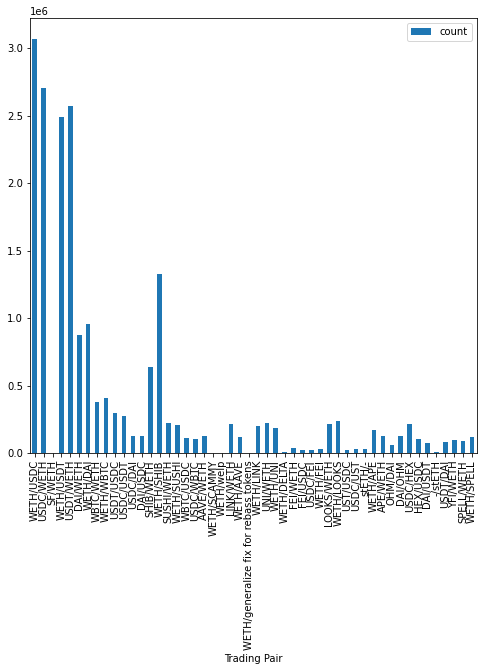

In [100]:
# Plot the data as a pie chart
pie = df2.plot(kind='bar', y='count', x='Trading Pair', figsize= (8,8))